In [1]:
import csv
import pandas as pd
import numpy as np
import pprint

### 1. Filtrage des flows

In [2]:
flows_to_Marseille = []
rank_Marseille = {}
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['destination_function'] == "O" \
        and row["source_suite"] == "la Santé registre de patentes de Marseille":
           # and row['toponyme_fr'] == 'Marseille' \
            flows_to_Marseille.append(row)
            rank_Marseille[row["source_doc_id"]] = row["travel_rank"]

In [3]:
ranks_smaller_than_Marseille = []
counter_uhgs_99999 = 0
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["source_suite"] == "la Santé registre de patentes de Marseille":
            if row["destination_uhgs_id"] == 'A9999997':
                counter_uhgs_99999 += 1
                continue
            if row["source_doc_id"] in rank_Marseille:
                max_rank = rank_Marseille[row["source_doc_id"]]
                if row["travel_rank"] <= max_rank:
                    ranks_smaller_than_Marseille.append(row)
counter_uhgs_99999

1202

### 2. Reconstitution des voyages

In [4]:
from collections import defaultdict
travels = defaultdict(lambda: {"total_miles": 0, "total_steps": 0, "keep": True})
null_distance = 0

for row in ranks_smaller_than_Marseille:
    doc_id = row["source_doc_id"]
    travel = travels[doc_id]
    distance = row["distance_dep_dest_miles"]
    if distance and distance != '0' and travel["keep"] and row["departure_out_date"]:
        travel["total_miles"] += int(distance)
        travel["total_steps"] += 1
        if row["travel_rank"] == "1":
            travel["departure_date"] = row["departure_out_date"]
        if row["travel_rank"] == rank_Marseille[doc_id]:
            travel["arrival_date"] = row["indate_fixed"] 
            travel["pavillon"] = row["ship_flag_standardized_fr"]
            travel["classe_bateau"] = row["ship_class_standardized"]
            year = row["indate_fixed"][:4]
            travel["year"] = year if year[-1] == "9" else year[:3]+"9"
    else:
        travel["keep"] = False

### 3. Suppression des voyages invalides

In [5]:
from datetime import datetime

good_travels = {}
error_list = []

for k, v in travels.items():
    if v["keep"] and ('<' not in v['departure_date'] and '>' not in v['departure_date']):
        travel = v.copy()
        end_time = datetime.strptime(v["arrival_date"], "%Y-%m-%d")
        try:
            start_time = datetime.strptime(v["departure_date"][:10], "%Y=%m=%d")
        except ValueError as e:
            error_list.append(e)
            continue
        travel["duration"] = (end_time - start_time).days
        if travel["duration"] == 0:
            travel["duration"] = 1
        travel["speed"] = v["total_miles"] / travel["duration"]
        travel["decade"] = v["arrival_date"][:4]
        travel.pop("keep")
        good_travels[k] = travel

In [6]:
df_travels = pd.DataFrame(good_travels).transpose()
df_travels = df_travels[df_travels.duration > 0]

### 4. Création des visualisations

In [7]:
viz_df = df_travels.groupby(['year', 'pavillon']).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'sum',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()

viz_df.columns = ['year', 'pavillon', 'mean_speed', 'mean_number_steps', 'sum_total_miles', 'count_travel', 'mean_duration']

viz_df["war"] = viz_df.year.isin(["1759", "1779", "1799"]).replace({True: "guerre", False: "paix"})

In [8]:
list_viz = []

for i,row in viz_df.iterrows():
    list_viz.append(dict(row))

In [9]:
from IPython.display import display

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

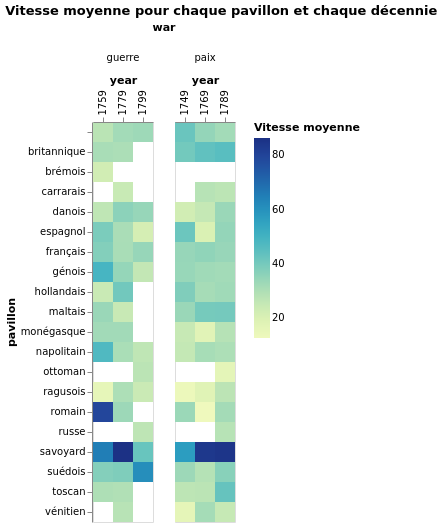

In [10]:
# Vitesse moyenne pour chaque pavillon et chaque décennie Heatmap, en temps de guerre et paix

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Vitesse moyenne pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "resolve": {"scale": {"x": "independent"}},
    "encoding": {
        "column": {"field": "war"},
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "mean_speed",
            "type": "quantitative",
            "title": "Vitesse moyenne"
        }
    }
})

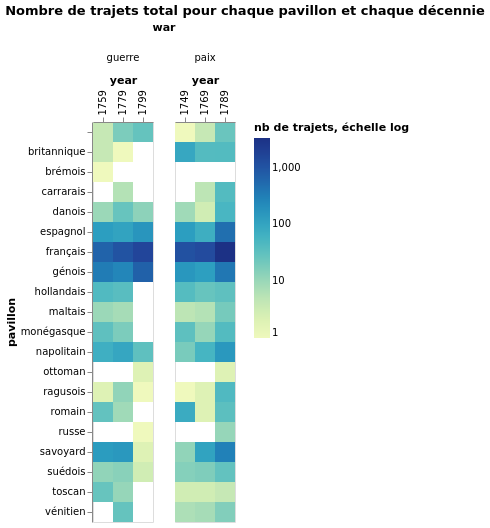

In [11]:
# Nombre de trajets total pour chaque pavillon et chaque décennie, en temps de guerre et paix

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre de trajets total pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "resolve": {"scale": {"x": "independent"}},
    "encoding": {
        "column": {"field": "war"},
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "count_travel",
            "type": "quantitative",
            "title": "nb de trajets, échelle log",
            "scale": {"type": "log"}
        }
    }
})


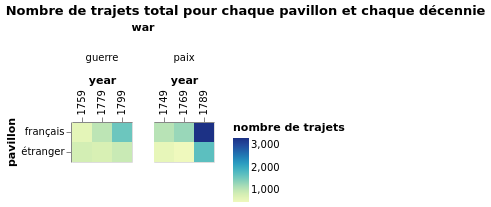

In [12]:
# Grouper les pavillons étrangers entre eux
df_travels["french_pavillon"] = df_travels.pavillon == "français"
df_travels["french_pavillon"] = df_travels["french_pavillon"].replace({True: "français", False: "étranger"})

viz_df = df_travels.groupby(['year', 'french_pavillon']).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'sum',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()
viz_df.columns = ['year', 'french_pavillon', 'mean_speed', 'mean_number_steps', 'sum_total_miles', 'count_travel', 'mean_duration']
viz_df["war"] = viz_df.year.isin(["1759", "1779", "1799"]).replace({True: "guerre", False: "paix"})

list_viz = []

for i,row in viz_df.iterrows():
    list_viz.append(dict(row))
    
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre de trajets total pour chaque pavillon et chaque décennie",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "resolve": {"scale": {"x": "independent"}},
    "encoding": {
        "column": {"field": "war"},
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "french_pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "count_travel",
            "type": "quantitative",
            "title": "nombre de trajets"
        }
    }
})

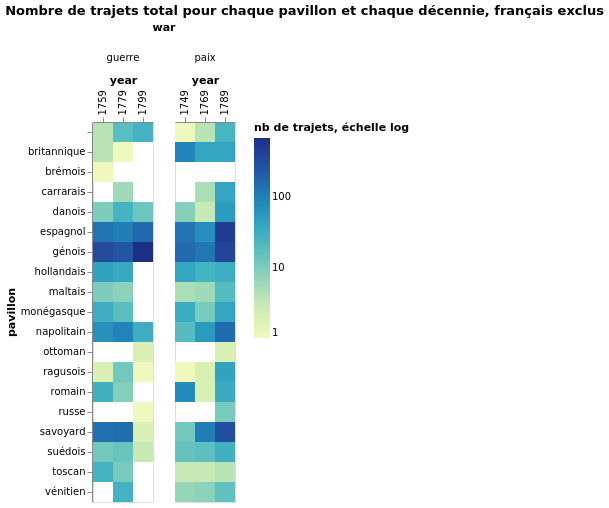

In [13]:
# Regarder uniquement les pavillons étrangers
viz_df = df_travels[df_travels.french_pavillon != "français"].groupby(['year', 'pavillon']).agg({'speed': 'mean',
                                                       'total_steps': 'mean',
                                                       'total_miles': 'sum',
                                                       'departure_date': 'size',
                                                       'duration': 'mean'
                                                       }
                                                      ).reset_index()
viz_df.columns = ['year', 'pavillon', 'mean_speed', 'mean_number_steps', 'sum_total_miles', 'count_travel', 'mean_duration']
viz_df["war"] = viz_df.year.isin(["1759", "1779", "1799"]).replace({True: "guerre", False: "paix"})

list_viz = []

for i,row in viz_df.iterrows():
    list_viz.append(dict(row))
    
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Nombre de trajets total pour chaque pavillon et chaque décennie, français exclus",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "rect"
    },
    "data": {
        "values": list_viz
    },
    "resolve": {"scale": {"x": "independent"}},
    "encoding": {
        "column": {"field": "war"},
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "pavillon",
            "type": "nominal",
            "title": "pavillon"
        },
        "color": {
            "field": "count_travel",
            "type": "quantitative",
            "title": "nb de trajets, échelle log",
            "scale": {"type": "log"}
        }
    }
})